In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
from cuml.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import cudf
import time
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact

Read the input data into a Pandas dataframe.  I gziped the file so that GitHub wouldn't complain

In [2]:
df = pd.read_csv("chembl_100k.smi.gz",sep=" ",header=None)

In [3]:
df.columns = ["SMILES","Name"]

In [4]:
df.head()

,SMILES,Name
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864


Define a function to calculate fingerprints

In [5]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp_list.append(fp_as_array(mol,n_bits))
        else:
            fp_list.append(None)
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Calculate the fingerprints

In [6]:
fp_list = fp_list_from_smiles_list(df.SMILES,1024)

### Remove any invalid fingerprints

Put the fingerprints into a Pandas dataframe

In [7]:
df['fp'] = fp_list

Check to make sure all of the fingerprints are OK

In [8]:
df[df.fp.isna()]

,SMILES,Name,fp


Check the dataframe again

In [9]:
df.head()

,SMILES,Name,fp
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [10]:
df.shape

(100000, 3)

Get rid of any cases where the fingerprint calculation didn't work

In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(100000, 3)

### K-Means Clustering

Function from the RAPIDS demos for converting a numpy array to a Cuda dataframe. 

In [13]:
def np2cudf(arr):
    # convert numpy array to cudf dataframe
    df = pd.DataFrame({'fea%d'%i:arr[:,i] for i in range(arr.shape[1])})
    pdf = cudf.DataFrame()
    for c,column in enumerate(df):
        pdf[str(c)] = df[column]
    return pdf

We're going to do some benchmarking.  Clustering on a CPU takes a while so we're going to benchmark on 10K fingerprints. 

In [14]:
desc = np.array(list(df.fp),dtype=np.float32)
desc_10k = desc[:10000]

Convert the descriptor array to a cudf

In [15]:
cu_df = np2cudf(desc_10k)

Check the amount of GPU memory being used

In [16]:
! nvidia-smi

Sun Jun 21 21:22:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   46C    P0    43W / 300W |    743MiB / 16160MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Benchmark the runtime for clustering 10K compounds into 100 to 1000 clusters

In [17]:
cluster_range = range(100,1001,100)

In [18]:
rp_rt_list = []
for n_clusters in tqdm(cluster_range):
    start = time.time()
    km = KMeans(n_clusters=n_clusters)
    km_res = km.fit_predict(cu_df)
    rp_rt_list.append([n_clusters, time.time()-start])

In [19]:
sk_rt_list = []
for n_clusters in tqdm(cluster_range):
    start = time.time()
    km = MiniBatchKMeans(n_clusters=n_clusters, init_size=3*n_clusters)
    km_res = km.fit_predict(desc_10k)
    sk_rt_list.append([n_clusters, time.time()-start])

In [20]:
rp_df = pd.DataFrame(rp_rt_list,columns=["Num Clusters","Runtime (sec)"])
rp_df['Method'] = 'GPU'
sk_df = pd.DataFrame(sk_rt_list,columns=["Num Clusters","Runtime (sec)"])
sk_df['Method'] = 'CPU'
rp_df = rp_df.append(sk_df)

Some settings to make the the plots appeal to my aesthetic sensibilities. 

In [21]:
sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Plot the data collected above

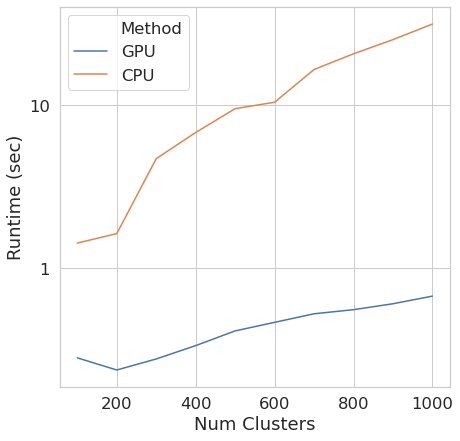

In [22]:
ax = sns.lineplot(rp_df["Num Clusters"],rp_df["Runtime (sec)"],data=rp_df,hue=rp_df["Method"])
_ = ax.set(yscale="log")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

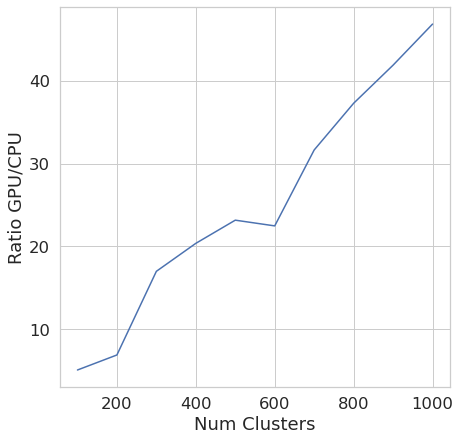

In [23]:
ratio_list = np.array(sk_rt_list)[:,1]/np.array(rp_rt_list)[:,1]
num_cluster_list = [x[0] for x in sk_rt_list]
ax = sns.lineplot(num_cluster_list,ratio_list)
_ = ax.set(xlabel="Num Clusters", ylabel="Ratio GPU/CPU")

### Rerun the benchmark with 100K fingerprints

In [24]:
cudf_100k = np2cudf(desc)

In [25]:
rp_rt_list = []
for n_clusters in tqdm(cluster_range):
    start = time.time()
    km = KMeans(n_clusters=n_clusters)
    km_res = km.fit_predict(cudf_100k)
    rp_rt_list.append([n_clusters, time.time()-start])

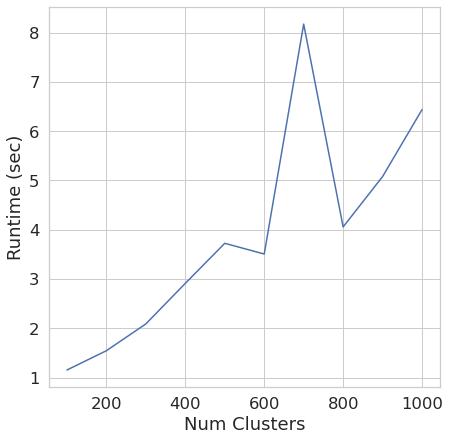

In [26]:
ax = sns.lineplot([x[0] for x in rp_rt_list],[x[1] for x in rp_rt_list])
_ = ax.set(xlabel="Num Clusters",ylabel="Runtime (sec)")

### Cluster and extract the results for visualization

In [27]:
km = KMeans(n_clusters=1000)
%time km_res = km.fit_predict(cudf_100k)
cluster_ids = km_res.to_array()

CPU times: user 3.86 s, sys: 2.58 s, total: 6.44 s
Wall time: 6.44 s


In [28]:
df['cluster'] = cluster_ids

In [29]:
df.head()

,SMILES,Name,fp,cluster
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",208
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",208
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",208
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",208
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",208


Set up a viewer to look through the clusters

In [30]:
@interact(cluster_id=range(1000))
def show_clusters(cluster_id):
    return MolsToGridImage([Chem.MolFromSmiles(x) for x in df.query(f'cluster == {cluster_id}').SMILES[:10]],molsPerRow=5)


interactive(children=(Dropdown(description='cluster_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…